In [1]:
import sys
sys.path.append('..')

import utils, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import random
from sklearn.linear_model import LinearRegression, RANSACRegressor

/Users/scrotti/Aptamer2025py/experiments/../indep_sites.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N"]

device = torch.device("cpu")
dtype = torch.float32
ts = range(len(round_ids))

In [20]:
from importlib import reload
reload(utils)
reload(callback)
reload(training)

<module 'training' from '/Users/scrotti/Aptamer2025py/experiments/../training.py'>

In [3]:
sequences, sequences_unique, counts, logmult = utils.sequences_counts_from_files(experiment_id, round_ids)
n_rounds = len(round_ids)

Extracting sequences...
Finished round ARN
Finished round R01
Finished round R02N


In [4]:
"""
Split sequences into train and test set by selecting for test `n_test` among the `n_top` sequences with the highest count at each round
"""
def split_train_test(sequences_t, n_test, n_top=None, sequences_unique_t=None, counts_t=None):
    if (sequences_unique_t is None) or (counts_t is None):
        sequences_unique_t, counts_t = torch.unique(sequences_t, dim=0, return_counts=True)
    perm = counts_t.argsort(descending=True)

    # take n_top sequences for test and n_top sequences for valid
    if n_top is None:
        n_top = len(sequences_unique_t)
    idx_2top = random.sample(range(n_top), 2*n_test)
    
    idx_test_ = idx_2top[:n_test]
    idx_train_top_ = idx_2top[n_test:2*n_test]
    assert len(idx_test_) == len(idx_train_top_) == n_test
    # idx_test_ = random.sample(range(n_top), n_test)
    # idx_train_ = torch.tensor([id for id in range(len(perm)) if not id in idx_test_])
    idx_test_bool_ = torch.zeros(len(perm), dtype=bool)
    idx_test_bool_[idx_test_] = True
    idx_train_bool_ = ~ idx_test_bool_
    idx_test = perm[idx_test_]
    idx_train = perm[idx_train_bool_]
    idx_train_top = perm[idx_train_top_]
    # check disjoint
    assert set(idx_test) & set(idx_train) == set()
    
    counts_perm_train_t = counts_t[idx_train]
    counts_perm_test_t = counts_t[idx_test]
    sequences_unique_train_t = sequences_unique_t[idx_train]
    sequences_unique_test_t = sequences_unique_t[idx_test]
    counts_perm_train_top_t = counts_t[idx_train_top]
    sequences_unique_train_top_t = sequences_unique_t[idx_train_top]
    
    sequences_train_t = torch.repeat_interleave(sequences_unique_train_t, counts_perm_train_t, dim=0)
    sequences_test_t = torch.repeat_interleave(sequences_unique_test_t, counts_perm_test_t, dim=0)
    sequences_train_top_t = torch.repeat_interleave(sequences_unique_train_top_t, counts_perm_train_top_t, dim=0)
    
    assert sequences_train_t.size(0) + sequences_test_t.size(0) == sequences_t.size(0)
    assert counts_perm_train_t.sum() + counts_perm_test_t.sum() == counts_t.sum()

    return sequences_unique_train_t, sequences_unique_test_t, sequences_unique_train_top_t, \
        sequences_train_t, sequences_test_t, sequences_train_top_t, \
        counts_perm_train_t, counts_perm_test_t, counts_perm_train_top_t

In [5]:
# n_test = 10
# n_top = 100
n_test = 10
n_top = 100

sequences_train = []
sequences_test = []
sequences_train_top = []
sequences_unique_train = []
sequences_unique_test = []
sequences_unique_train_top = []
counts_train = []
counts_train_top = []
counts_test = []

for t in ts:
    print(f'Starting round {t} of {len(ts)-1}...')
    (sequences_unique_train_t, sequences_unique_test_t, sequences_unique_train_top_t, \
    sequences_train_t, sequences_test_t, sequences_train_top_t, \
    counts_train_t, counts_test_t, counts_train_top_t) = \
        split_train_test(sequences[t], n_test, n_top, sequences_unique[t], counts[t])
    sequences_train.append(sequences_train_t)
    sequences_train_top.append(sequences_train_top_t)
    sequences_test.append(sequences_test_t)
    sequences_unique_train.append(sequences_unique_train_t)
    sequences_unique_train_top.append(sequences_unique_train_top_t)
    sequences_unique_test.append(sequences_unique_test_t)
    counts_train.append(counts_train_t)
    counts_train_top.append(counts_train_top_t)
    counts_test.append(counts_test_t)

Starting round 0 of 2...
Starting round 1 of 2...
Starting round 2 of 2...


In [7]:
sequences_train_oh = [one_hot(sequences_train[t]).to(dtype=dtype) for t in ts]
sequences_test_oh = [one_hot(sequences_test[t]).to(dtype=dtype) for t in ts]
sequences_unique_train_oh = [one_hot(sequences_unique_train[t]).to(dtype=dtype) for t in ts]
sequences_unique_test_oh = [one_hot(sequences_unique_test[t]).to(dtype=dtype) for t in ts]
sequences_train_top_oh = [one_hot(sequences_train_top[t]).to(dtype=dtype) for t in ts]
sequences_unique_train_top_oh = [one_hot(sequences_unique_train_top[t]).to(dtype=dtype) for t in ts]
logmult_test = torch.tensor([utils.log_multinomial(counts_test[t]) for t in ts])
logmult_train_top = torch.tensor([utils.log_multinomial(counts_train_top[t]) for t in ts])
logmult_train = torch.tensor([utils.log_multinomial(counts_train[t]) for t in ts])

In [33]:
logmult_test, logmult_train_top, logmult_train

(tensor([  1398.1809,   1473.2512, 117140.3125]),
 tensor([ 1694.7388,  1610.7354, 94674.0312]),
 tensor([1.4602e+08, 7.4753e+07, 2.5497e+08]))

In [21]:
[len(s) for s in sequences_unique_test_oh], [len(s) for s in sequences_unique_train_top_oh], [len(s) for s in sequences_test_oh], [len(s) for s in sequences_train_top_oh]

([10, 10, 10], [10, 10, 10], [638, 689, 55086], [764, 761, 50040])

In [22]:
counts_train_top, counts_test

([tensor([ 94,  71,  46, 101,  64,  98,  48,  77,  48, 117]),
  tensor([ 42,  47,  48, 130,  33, 143, 129, 106,  45,  38]),
  tensor([  977,  1938, 16651, 10373,  7902,  4366,  3332,  1792,  1029,  1680])],
 [tensor([ 43,  86,  85,  35,  48,  76,  37,  82,  42, 104]),
  tensor([ 64,  40,  33,  42,  62,  37, 104, 149,  52, 106]),
  tensor([3202, 3126, 7246, 8905, 3463, 1891, 7647, 9174, 1011, 9421])])

In [10]:
total_reads_train = torch.Tensor([s.shape[0] for s in sequences_train_oh])
total_reads_test = torch.Tensor([s.shape[0] for s in sequences_test_oh])
n_rounds = len(sequences_train_oh) 

In [64]:
from callback import Callback

class HighCountLogLikelihoodCallback(Callback):
    def __init__(self, good_sequences_train, logmult_train_top: torch.Tensor, device=torch.device('cpu')):
        super().__init__()
        self.nll_train = []
        self.nll_valid = []
        self.train_top_dl = [data_loading.SelexRoundDataLoader(seq_oh, device=device) for seq_oh in good_sequences_train]
        self.total_reads_train_top = torch.Tensor([s.shape[0] for s in good_sequences_train])
        self.logmult_train_top = logmult_train_top

    def after_step(self, model, log_weights, log_likelihood_valid, *args, **kwargs):
        batches = [next(iter(dl)) for dl in self.train_top_dl]
        nll_train = - training.estimate_log_likelihood(model, batches, self.total_reads_train_top, log_weights, self.logmult_train_top)
        nll_valid = - log_likelihood_valid
        self.nll_train.append(nll_train)
        self.nll_valid.append(nll_valid)
        return False

    def plot(self, **kwargs):
        fig, ax = plt.subplots(**kwargs)
        ax.plot(self.nll_train, label='training')
        ax.plot(self.nll_valid, label='validation')
        ax.set_xlabel('iter')
        ax.set_ylabel('NLL')
        ax.legend()

        return fig, ax

In [100]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")

selected_modes = torch.BoolTensor(
    [[1], [1]]
)

L, q = sequences_train_oh[0][0].shape

k = torch.zeros(L, q, dtype=dtype)
h = torch.zeros(L, q, dtype=dtype)
# J = torch.zeros(L, q, L, q, dtype=dtype)
# J = utils.rand_coupling_matrix(L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
mode = energy_models.IndepSites(h)

ps = selex_distribution.MultiModeDistribution(mode, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [101]:
from importlib import reload
reload(utils)
reload(callback)
reload(training)

<module 'training' from '/Users/scrotti/Aptamer2025py/experiments/../training.py'>

In [102]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback(), 
             HighCountLogLikelihoodCallback(sequences_train_top_oh, logmult_train_top, device)
            ]

In [103]:
device = torch.device('cpu')

batch_size = 10**4
data_loaders_train = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_train_oh]
data_loaders_test = [data_loading.SelexRoundDataLoader(seq_oh, device=device) for seq_oh in sequences_test_oh]

n_chains = 10**2
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [107]:
n_sweeps = 10
lr = 0.01
max_epochs = 6000

training.train(model, data_loaders_train, total_reads_train, chains, n_sweeps, max_epochs, lr=lr, 
               callbacks=callbacks, log_weights=log_weights, 
               log_multinomial_factors=logmult_train, log_multinomial_factors_valid=logmult_test,
               data_loaders_valid=data_loaders_test, total_reads_valid=total_reads_test)

 0.00%[                                  ] Epoch: 0/6000 [00:00, ?it/s]

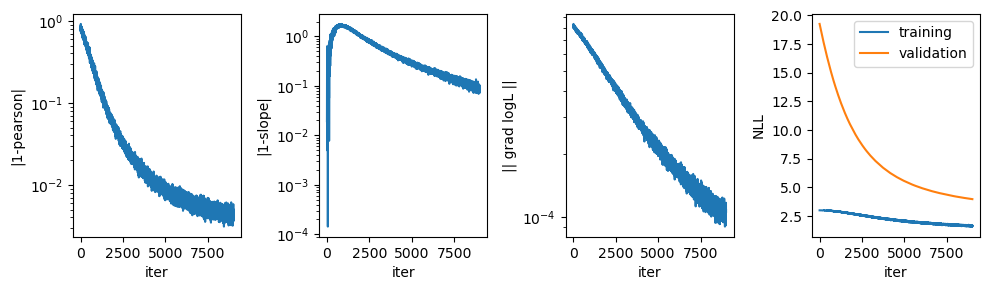

In [108]:
fig, axes = callbacks[0].plot();

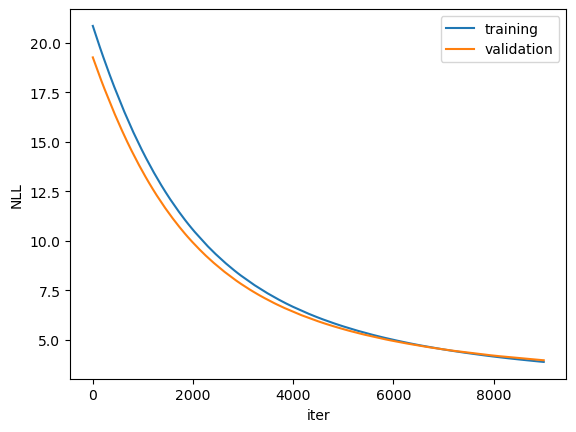

In [109]:
fig, axes = callbacks[2].plot();

## Picking test sequences not among the highest counts

In [ ]:
n_test = 10**4
n_top = None

sequences_train = []
sequences_test = []
sequences_train_top = []
sequences_unique_train = []
sequences_unique_test = []
sequences_unique_train_top = []
counts_train = []
counts_train_top = []
counts_test = []

for t in ts:
    print(f'Starting round {t} of {len(ts)-1}...')
    (sequences_unique_train_t, sequences_unique_test_t, sequences_unique_train_top_t, \
    sequences_train_t, sequences_test_t, sequences_train_top_t, \
    counts_train_t, counts_test_t, counts_train_top_t) = \
        split_train_test(sequences[t], n_test, n_top, sequences_unique[t], counts[t])
    sequences_train.append(sequences_train_t)
    sequences_train_top.append(sequences_train_top_t)
    sequences_test.append(sequences_test_t)
    sequences_unique_train.append(sequences_unique_train_t)
    sequences_unique_train_top.append(sequences_unique_train_top_t)
    sequences_unique_test.append(sequences_unique_test_t)
    counts_train.append(counts_train_t)
    counts_train_top.append(counts_train_top_t)
    counts_test.append(counts_test_t)

In [ ]:
sequences_train_oh = [one_hot(sequences_train[t]).to(dtype=dtype) for t in ts]
sequences_test_oh = [one_hot(sequences_test[t]).to(dtype=dtype) for t in ts]
sequences_unique_train_oh = [one_hot(sequences_unique_train[t]).to(dtype=dtype) for t in ts]
sequences_unique_test_oh = [one_hot(sequences_unique_test[t]).to(dtype=dtype) for t in ts]
sequences_train_top_oh = [one_hot(sequences_train_top[t]).to(dtype=dtype) for t in ts]
sequences_unique_train_top_oh = [one_hot(sequences_unique_train_top[t]).to(dtype=dtype) for t in ts]
logmult_test = torch.tensor([utils.log_multinomial(counts_test[t]) for t in ts])
logmult_train_top = torch.tensor([utils.log_multinomial(counts_train_top[t]) for t in ts])
logmult_train = torch.tensor([utils.log_multinomial(counts_train[t]) for t in ts])
total_reads_train = torch.Tensor([s.shape[0] for s in sequences_train_oh])
total_reads_test = torch.Tensor([s.shape[0] for s in sequences_test_oh])

In [ ]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")

selected_modes = torch.BoolTensor(
    [[1], [1]]
)

L, q = sequences_train_oh[0][0].shape

k = torch.zeros(L, q, dtype=dtype)
h = torch.zeros(L, q, dtype=dtype)
# J = torch.zeros(L, q, L, q, dtype=dtype)
# J = utils.rand_coupling_matrix(L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
mode = energy_models.IndepSites(h)

ps = selex_distribution.MultiModeDistribution(mode, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [139]:
logNst_test = [- model.compute_energy_up_to_round(sequences_unique_test_oh[t], t).detach().cpu()
               for t in ts]

In [78]:
def scatter_with_fit(x, y, **kwargs):
    fig, ax = plt.subplots(figsize=(3,3))
    ax.scatter(x, y, **kwargs)
    reg = RANSACRegressor().fit(x.reshape(-1, 1), y)
    ax.plot(x, reg.predict(x.reshape(-1,1)), color='r', linewidth=1, label='Robust fit')
    return fig, ax

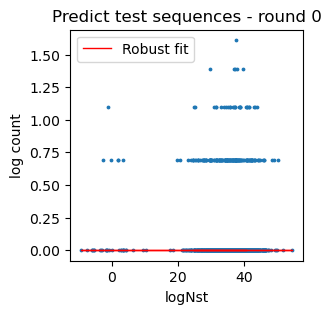

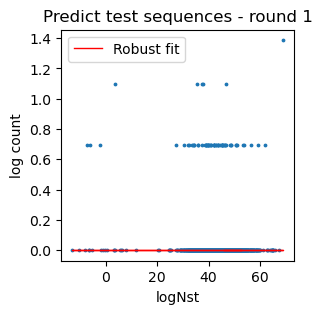

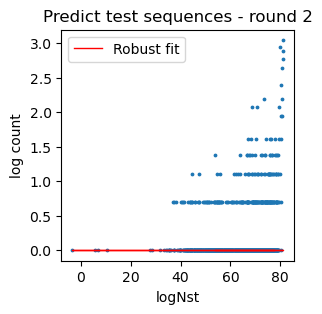

In [79]:
for t in ts:
    fig, ax = scatter_with_fit(logNst_test[t], torch.log(counts_test[t]), s=3)
    ax.set_xlabel('logNst')
    ax.set_ylabel('log count')
    ax.legend()
    ax.set_title(f'Predict test sequences - round {t}')